In [1]:
# !pip install pandas_datareader
# !pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas_datareader as pdr
import yfinance as yf

2023-10-22 16:35:04.814923: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 16:35:04.815026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 16:35:04.815050: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 16:35:04.825567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = yf.download("AAPL", start="2013-10-16", end="2023-10-16").reset_index()
print("Data Shape after load: ", data.shape)

[*********************100%%**********************]  1 of 1 completed
Data Shape after load:  (2516, 7)


In [4]:
import sklearn.preprocessing as preprocessing

# data cleaning
data = data.ffill()
data = data.drop(['Date'], axis=1)
#check na
if data.isna().sum().sum() != 0:
    print("There are still NA values")
    data = data.bfill()

print("Data Shape after cleaning: ", data.shape)

cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# perform scaling
scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(data[cols])
    
print("Data Shape after removing outliers: ", data.shape)

Data Shape after cleaning:  (2516, 6)
Data Shape after removing outliers:  (2516, 6)


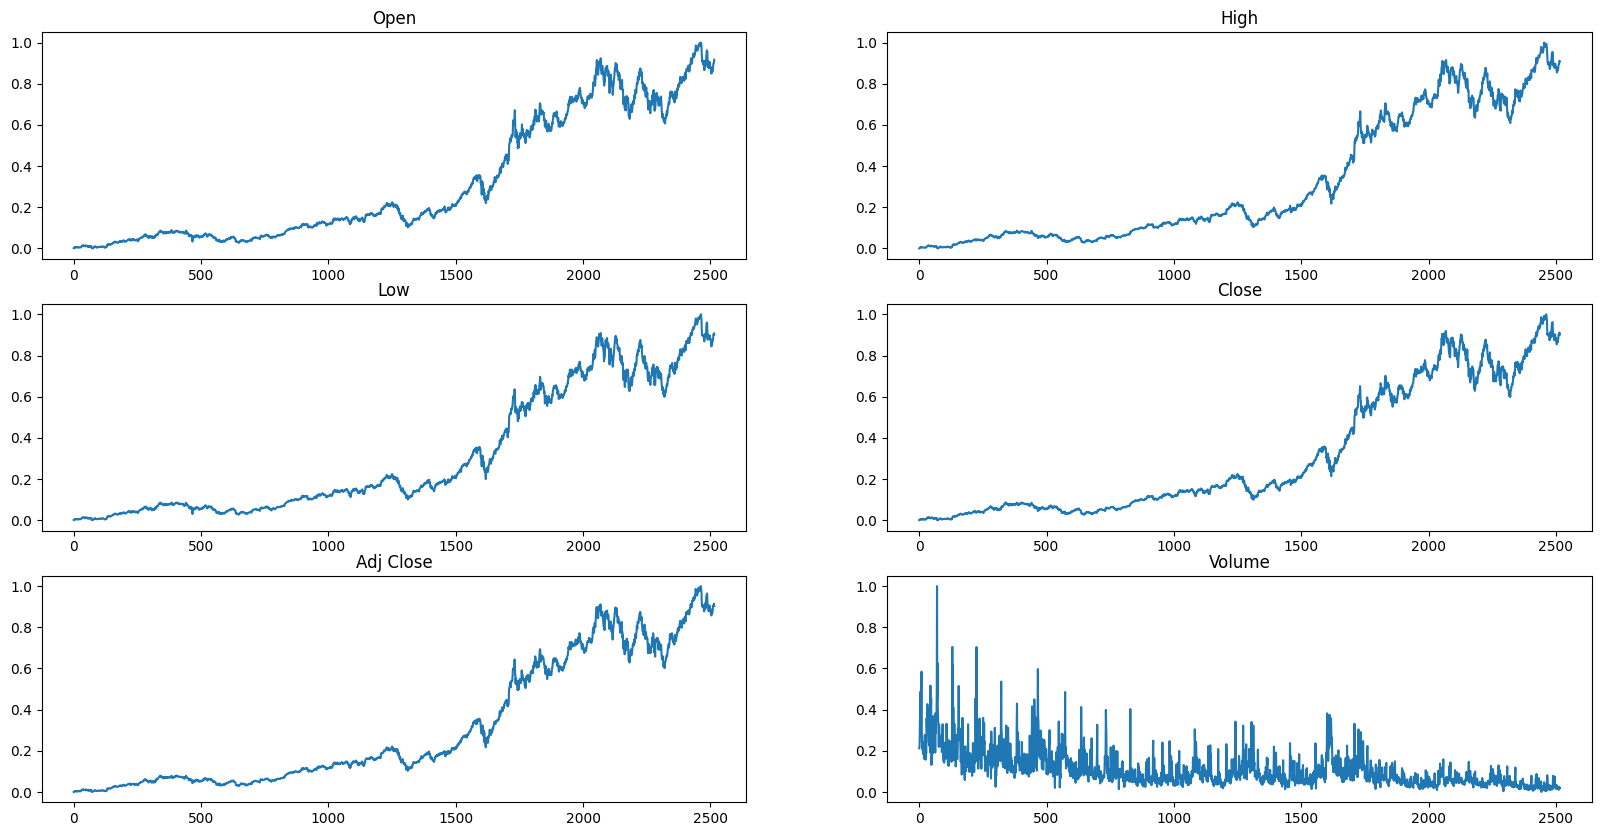

In [5]:
# plot distribution of the price as line graphs per subplot
dateSeries = range(0, data.shape[0])
plt.figure(figsize=(20, 10))
for i in range(0, data.shape[1]):
    plt.subplot(3, 2, i+1)
    plt.plot(dateSeries, data[:, i])
    plt.title(cols[i])


In [6]:
numberOfInputDays = 7
numberOfDaysToPredict = 1

# create sequence
def create_sequence(data, numberOfInputDays, numberOfDaysToPredict):
    x = []
    y = []
    # for i in range(numberOfInputDays, data.shape[0] - numberOfDaysToPredict + 1):
    #     x.append(data.iloc[i-numberOfInputDays:i, 1:len(cols)+1])
    #     y.append(data.iloc[i:i+numberOfDaysToPredict][cols])
    # return np.array(x), np.array(y)
     
    for i in range(len(data)-numberOfInputDays):
        x.append(data[i:i+numberOfInputDays])
        y.append(data[i+numberOfInputDays])
    return np.array(x), np.array(y)
    
X, Y = create_sequence(data, numberOfInputDays, numberOfDaysToPredict)

print("X Shape: ", X.shape)
print("Y Shape ", Y.shape)

X Shape:  (2509, 7, 6)
Y Shape  (2509, 6)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False, test_size=0.2)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print("X_train Shape: ", X_train.shape)
print("Y_train Shape: ", Y_train.shape)
print("X_test Shape: ", X_test.shape)
print("Y_test Shape: ", Y_test.shape)


X_train Shape:  (2007, 7, 6)
Y_train Shape:  (2007, 6)
X_test Shape:  (502, 7, 6)
Y_test Shape:  (502, 6)


In [28]:
# apply RNN
def defineModel(numberOfInputDays,units):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=units, input_shape=(numberOfInputDays, len(cols))))
    model.add(keras.layers.Dense(units=16, activation='relu'))
    model.add(keras.layers.Dense(units=len(cols), activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [29]:
def fitModelToHyperparameter(X_train, Y_train,numberOfInputDays, units, epochs, batchSize):
    model = defineModel(numberOfInputDays, units)
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batchSize, validation_split=0.1)
    return model, history

def gridSearch(units, epochs, batchSizes):
    bestMSE = float('inf')
    bestPrarams = None
    bestModel = None
    bestHistory = None
    numberOfIters = len(units) * len(epochs) * len(batchSizes)
    currentIter = 1
    for unit in units:
        for epoch in epochs:
            for batchSize in batchSizes:
                print(f"Case : {currentIter}/{numberOfIters}")
                print("Unit: ", unit, "Epoch: ", epoch, "Batch Size: ", batchSize)
                fittedModel,fittedHistory = fitModelToHyperparameter(X_train, Y_train, numberOfInputDays, unit, epoch, batchSize)
                current_y_pred = fittedModel.predict(X_test)
                current_y_pred = scaler.inverse_transform(current_y_pred)
                y_actual = scaler.inverse_transform(Y_test.reshape(-1, len(cols)))
                mean_squared_error = metrics.mean_squared_error(y_actual, current_y_pred)
                currentIter += 1
                
                if mean_squared_error < bestMSE:
                    bestMSE = mean_squared_error
                    bestPrarams = {'units': unit, 'epochs': epoch, 'batch_size': batchSize}
                    bestModel = fittedModel
                    bestHistory = fittedHistory
    print("Best MSE: ", bestMSE)
    print("Best Params: ", bestPrarams)
    return bestModel, bestHistory


In [30]:
bestModel,bestHistory = gridSearch([32, 64, 128], [10, 20, 30], [16, 32, 64])

Case : 1/27
Unit:  32 Epoch:  10 Batch Size:  16
Epoch 1/10
113/113 [==============================] - 3s 11ms/step - loss: 0.0135 - val_loss: 0.0747
Epoch 2/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0104 - val_loss: 0.0040
Epoch 3/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 4/10
113/113 [==============================] - 1s 9ms/step - loss: 9.4968e-04 - val_loss: 0.0019
Epoch 5/10
113/113 [==============================] - 1s 9ms/step - loss: 8.3683e-04 - val_loss: 0.0012
Epoch 6/10
113/113 [==============================] - 1s 9ms/step - loss: 8.0835e-04 - val_loss: 8.7817e-04
Epoch 7/10
113/113 [==============================] - 1s 9ms/step - loss: 7.7248e-04 - val_loss: 4.7285e-04
Epoch 8/10
113/113 [==============================] - 1s 8ms/step - loss: 7.4704e-04 - val_loss: 5.9966e-04
Epoch 9/10
113/113 [==============================] - 1s 8ms/step - loss: 7.3773e-04 - val_loss: 6.0781e-04
Epoch 10/1

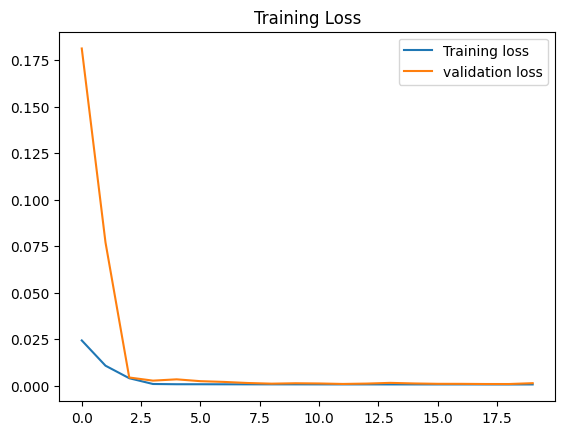

In [31]:
# print history data
plt.plot(bestHistory.history['loss'], label='Training loss')
plt.plot(bestHistory.history['val_loss'], label='validation loss')
plt.legend()
plt.title("Training Loss")
plt.show()

In [45]:
# Total Mean Squared Error for test
loss = bestModel.evaluate(X_test, Y_test)
print("Loss:", loss)
from sklearn import metrics

mse = metrics.mean_squared_error(Y_test, bestModel.predict(X_test))
print("MSE: ",mse)

rmse = np.sqrt(metrics.mean_squared_error(Y_test, bestModel.predict(X_test)))
print("Root MSE: ",rmse)

mae = metrics.mean_absolute_error(Y_test, bestModel.predict(X_test))
print("MAE: ",mae)

16/16 [==============================] - 0s 6ms/step - loss: 0.0098
Loss: 0.009791727177798748
16/16 [==============================] - 0s 3ms/step
MSE:  0.009791727816845576
16/16 [==============================] - 0s 4ms/step
Root MSE:  0.09895315971127741
16/16 [==============================] - 0s 3ms/step
MAE:  0.08190969057937593


In [33]:
def predict(model, data):
    with tf.device('/device:GPU:0'):
        last_n_days = data[-numberOfInputDays:]
        last_n_days = last_n_days.reshape((1, numberOfInputDays, len(cols)))
        prediction = model.predict(last_n_days)
        real_predicted_price = scaler.inverse_transform(prediction)
    return real_predicted_price

In [34]:
predicted_price = predict(bestModel, data)

1/1 [==============================] - 0s 26ms/step


In [35]:
print("Predicted Price: ", predicted_price)

Predicted Price:  [[1.4815170e+02 1.5348825e+02 1.5582426e+02 1.5585051e+02 1.4733078e+02
  4.7769928e+07]]


In [18]:
#save model
# bestModel.save('task2.keras')

In [19]:
# # data to use for testing flask 
# import yfinance as yf
# data = yf.download("AAPL", start="2021-10-20", end="2021-10-29").reset_index()
# data
# # date = "2021-10-10"
# # date = pd.to_datetime(date)
# # date
# # save as csv 
# data.to_csv('task2.csv', index=False)

In [20]:
# date = date+pd.DateOffset(days=1)
# date